In [1]:
import numpy as np
#import scipy as sp
import pandas as pd
#from scipy import stats
import os
#import keras
#from keras.utils import to_categorical
#from keras import Sequential
#from keras.layers import Dense
#from keras.callbacks import EarlyStopping
#from keras.callbacks import ModelCheckpoint
#from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings("ignore")

# The following data are obtained from https://github.com/hwchase17/sportvu

data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]


data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]



In [50]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# if you want to use the pre-trained model the variable TRAIN_MODEL should be set to FALSE
TRAIN_MODEL = False

if TRAIN_MODEL:

    data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
    data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
    data = data.dropna()
    # here you can change the argument for training with a different season
    data = data[data['season'] == '2014']

    data = data.drop(['season'], axis = 1)

    train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
    train_y = to_categorical(data['SHOT_MADE_FLAG'])


    early_stopping_monitor = EarlyStopping(patience=3,min_delta = 0.01,monitor='val_acc')
    model_check_point = ModelCheckpoint("shot_make_model_plosone_pred13/model_sm.{epoch:02d}-{val_acc:.2f}.hdf5",monitor = 'val_acc',mode = 'max',save_best_only = True)

    model= Sequential()
    n_cols = train_X.shape[1]
    model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_X, train_y, epochs=5,validation_split=0.2, callbacks=[model_check_point,early_stopping_monitor])

In [51]:
model13 = keras.models.load_model('paper_models/model13.hdf5')
model14 = keras.models.load_model('paper_models/model14.hdf5')


data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG","season"]]
test = pd.get_dummies(test,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
test = test.dropna()

tmp = test[test["season"] == '2013']
predictions13 =  model13.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1))
tmp = test[test["season"] == '2014']
predictions14 =  model14.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1))

test = data
test = test.dropna()

test['prob'] = list(predictions13[:,1])+list(predictions14[:,1])

Test set accuracy:  0.6524133991594925
The model's brier score is:  0.21666628762688916
The climatology's brier score is:  0.24793219794785007


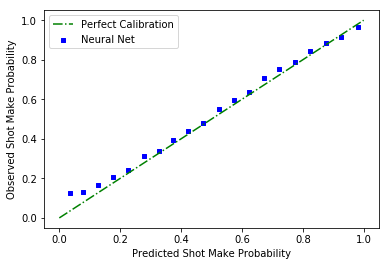

In [65]:
# evaluate the error on the data that will not be used for the hot hand

SHOT_THRES = 1000


predictions = []
shot_outcome = []

shots_pl = test.groupby('PLAYER_ID')

players = []

for p in test['PLAYER_ID'].unique():
    if len(shots_pl.get_group(p)) > SHOT_THRES:
        players.append(p)
                
for p in players: 
    player_df = shots_pl.get_group(p)
    player_df_games = player_df.groupby("GAME_ID")
    # find the games that we have full data for the player
    games_p = []
    good_shots = 0
    for g in player_df['GAME_ID'].unique():
        tmp = player_df_games.get_group(g)
        if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
            games_p.append(g)
            good_shots += len(tmp.SHOT_NUMBER)
    
    for g in games_p:
        tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
        tmp_prob = list(player_df_games.get_group(g)['prob'])
        for i in range(len(list(tmp))-1):
            if list(tmp)[i] == 1:
                predictions.append(list(tmp_prob)[i+1])
                shot_outcome.append(list(tmp)[i+1])

print("Test set accuracy: ",np.sum(np.round(predictions) == shot_outcome)/len(shot_outcome))

# brier score

print("The model's brier score is: ",  brier_score_loss(shot_outcome,predictions))
print("The climatology's brier score is: ", brier_score_loss(shot_outcome,(sum(shot_outcome)/len(shot_outcome))*np.ones(len(shot_outcome))))
observed, predicted = calibration_curve(shot_outcome, predictions, n_bins = 20)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.linspace(0,1,10000)
y = x
ax1.plot(x,y,'-.g',label="Perfect Calibration")

ax1.scatter(predicted,observed,s=20, c='b', marker="s", label = "Neural Net")


plt.xlabel("Predicted Shot Make Probability")
plt.ylabel("Observed Shot Make Probability")
plt.legend(loc='upper left');
plt.show()

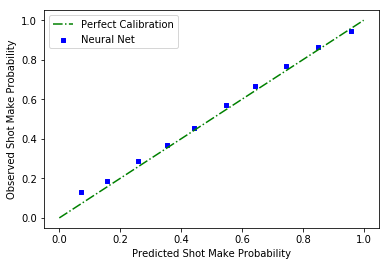

In [214]:
observed, predicted = calibration_curve(shot_outcome, predictions, n_bins = 10)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.linspace(0,1,10000)
y = x
ax1.plot(x,y,'-.g',label="Perfect Calibration")

ax1.scatter(predicted,observed,s=20, c='b', marker="s", label = "Neural Net")


plt.xlabel("Predicted Shot Make Probability")
plt.ylabel("Observed Shot Make Probability")
plt.legend(loc='upper left');
plt.show()

In [62]:
observed-predicted

array([ 0.04801828,  0.02604117,  0.02971393,  0.02404748,  0.02939483,
        0.02218874,  0.02813778,  0.02973433, -0.01127828, -0.01846898])

In [184]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-1):
                if list(tmp)[i] == 1:
                    probs_all.append(probs[i+1])
                    n_shots = n_shots+1
                    if list(tmp)[i+1] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
        fg_null = []
        xfg_null = []
        adjusted_hh =[]
        tt_prob_sim = []

        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                probs = list(player_df_games.get_group(g)['prob'])
                tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
                for i in range(len(list(tmp))-1):
                    if list(tmp)[i] == 1:
                        if list(tmp)[i+1] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1

                        
            tt_prob_sim.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim)))
            t = player_df.sample(n_shots)
            adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
            #model_error.append(-(make_null/(make_null+miss_null))+(model_error_make/(model_error_make+model_error_miss)))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",np.mean(tt_prob_sim),",",np.mean(adjusted_hh),",",stats.ttest_1samp(adjusted_hh,0)[1])        





LaMarcus Aldridge , 654 , 0.0071234854155603124 , -0.017515140093929803 , 6.690067460768895e-10
Randy Foye , 306 , 0.013665257789067775 , -0.010173571003666892 , 0.00785001242768262
Rudy Gay , 677 , 0.05001260867296936 , 0.022834689946723927 , 1.393044457530071e-16
JJ Redick , 458 , 0.012122036249922334 , -0.015505678080725383 , 3.047745076339287e-06
Mike Dunleavy , 395 , -0.03055566695839275 , -0.047866098734182974 , 1.6200722825076918e-29
Kyle Lowry , 478 , -0.03235537277947665 , -0.043834552074934585 , 1.974765855725215e-27
PJ Tucker , 339 , 0.007468728343748683 , -0.009608723610217938 , 0.015301997662125475
Paul Millsap , 618 , 0.016890159943678158 , -0.006426476428522723 , 0.02726626477547846
Jose Juan Barea , 313 , -0.026537943914459995 , -0.021534892441697675 , 1.3777382736174605e-07
Pau Gasol , 671 , -0.014670613940301202 , -0.042050167343490236 , 2.5459512317799574e-32
Joe Johnson , 491 , -0.0030520312731004214 , -0.026578682487779663 , 7.691632022076423e-15
Zach Randolph , 67

Nicolas Batum , 502 , -0.0071542385002089405 , -0.01567845889323709 , 7.35462849802066e-08
George Hill , 336 , 0.01082459722793847 , -0.030537703258853233 , 9.978717920584376e-15
Mario Chalmers , 342 , -0.003265815856342446 , -0.01930894831940951 , 3.015608130573719e-08
Goran Dragic , 689 , 0.010672045657520167 , -0.016080963051010665 , 1.223961877554358e-09
Anthony Morrow , 318 , -0.015334776300369836 , -0.04426118627885968 , 1.1815253235236992e-20
Carmelo Anthony , 571 , 0.02736977476267177 , -0.010711937345661993 , 0.00014355017414087638
Blake Griffin , 928 , 0.024078440614497 , -0.007705629722790564 , 0.0002651527144964081
James Harden , 507 , 0.025012697912563952 , -0.004172270482583682 , 0.1694257975461268
Tyreke Evans , 440 , 0.03592425025613652 , 0.006947936406373584 , 0.031950886639902386
Stephen Curry , 674 , -0.003956581371436606 , -0.02117125203270141 , 5.416410790900753e-14
Jordan Hill , 418 , 0.0504562181560673 , 0.01893095017282864 , 6.932163451874133e-10
DeMar DeRozan ,

In [185]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-2):
                if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1):
                    probs_all.append(probs[i+2])
                    n_shots = n_shots+1
                    if list(tmp)[i+2] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
                
        fg_null = []
        xfg_null = []
        adjusted_hh = []
        tt_prob_sim = []

        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                probs = list(player_df_games.get_group(g)['prob'])
                tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
                for i in range(len(list(tmp))-2):
                    if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1):
                        if list(tmp)[i+2] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1
                    
                        
            tt_prob_sim.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim)))
            t = player_df.sample(n_shots)
            adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
            #model_error.append(-(make_null/(make_null+miss_null))+(model_error_make/(model_error_make+model_error_miss)))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",np.mean(tt_prob_sim),",",np.mean(adjusted_hh),",",stats.ttest_1samp(adjusted_hh,0)[1])




LaMarcus Aldridge , 287 , 0.0049544165771920785 , -0.02249027583627009 , 1.772931518904013e-07
Randy Foye , 113 , -0.002401936288902282 , -0.01716216901987695 , 0.00977041731026651
Rudy Gay , 316 , 0.04219542336599298 , 0.012925893402727122 , 0.0015156857600778378
JJ Redick , 193 , 0.022282675026486932 , -0.005112055116491876 , 0.21158193907990128
Mike Dunleavy , 135 , -0.043683235654256004 , -0.05020039505607458 , 4.685603252361237e-13
Kyle Lowry , 170 , -0.0448474769494522 , -0.051928754581113665 , 3.175925933276477e-17
PJ Tucker , 121 , 0.06124678488164772 , 0.04742878974105701 , 2.2718479614068369e-10
Paul Millsap , 265 , 0.03130479235935745 , 0.00476098031750124 , 0.31034237547284416
Jose Juan Barea , 105 , 0.0019692886053688614 , 0.005758172930410521 , 0.34144487141035496
Pau Gasol , 271 , -0.035407335697289516 , -0.06303685968608894 , 1.489678966059465e-27
Joe Johnson , 195 , -0.0027302716453533452 , -0.029509494617089203 , 3.9139319014607686e-07
Zach Randolph , 291 , 0.01348077

George Hill , 128 , -0.01776745404484495 , -0.05605023387634241 , 4.340573813807038e-15
Mario Chalmers , 133 , -0.01946709245571132 , -0.03289374912159397 , 1.6489320564927007e-07
Goran Dragic , 317 , 0.010227461385091284 , -0.011596890416131336 , 0.0021156393092104223
Anthony Morrow , 111 , -0.062033021213756444 , -0.09159857102273868 , 2.729222743634248e-28
Carmelo Anthony , 242 , 0.01865635220489592 , -0.018395968221295505 , 0.00048058043173508186
Blake Griffin , 451 , 0.005973351082099057 , -0.026410059088443103 , 4.37495983068356e-14
James Harden , 209 , 0.0033861463101803246 , -0.023398325843586826 , 4.538253448434673e-06
Tyreke Evans , 189 , 0.01320842807726822 , -0.018469952193727865 , 2.016299487594356e-05
Stephen Curry , 300 , -0.025269038384147798 , -0.0470540522715892 , 2.3646602320379315e-23
Jordan Hill , 189 , 0.10031521070683543 , 0.06901297747018575 , 1.4232491808379653e-24
DeMar DeRozan , 230 , -0.0461674914702042 , -0.056415671181767636 , 1.5658291655351843e-25
Brando

In [186]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-3):
                if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1) and (list(tmp)[i+2] == 1):
                    probs_all.append(probs[i+3])
                    n_shots = n_shots+1
                    if list(tmp)[i+3] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
                
        fg_null = []
        xfg_null = []
        adjusted_hh = []
        tt_prob_sim = []
        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                probs = list(player_df_games.get_group(g)['prob'])
                tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
                for i in range(len(list(tmp))-3):
                    if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1) and (list(tmp)[i+2] == 1):
                        if list(tmp)[i+3] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1
                    
                        
            tt_prob_sim.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim)))
            t = player_df.sample(n_shots)
            adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",np.mean(tt_prob_sim),",",np.mean(adjusted_hh),",",stats.ttest_1samp(adjusted_hh,0)[1])



LaMarcus Aldridge , 128 , 0.05188878023003383 , 0.03163692721801965 , 2.9095936529018655e-06
Randy Foye , 38 , -0.028693262236432312 , -0.043076019569196475 , 0.002151968208816983
Rudy Gay , 147 , 0.037576074625140427 , 0.01095591329680239 , 0.10014503219065148
JJ Redick , 84 , -0.039300600546343795 , -0.07109790147918402 , 1.0225470746068482e-15
Mike Dunleavy , 44 , -0.03857323403422324 , -0.042286958957289365 , 1.3033800693190092e-06
Kyle Lowry , 56 , -0.03794106785777347 , -0.05844042778517973 , 3.791636006974359e-10
PJ Tucker , 44 , 0.006301574435235808 , -0.003332198166561027 , 0.7638580993128112
Paul Millsap , 120 , -0.008087881145232663 , -0.0400711806874511 , 1.252378803774818e-10
Jose Juan Barea , 37 , 0.13962213344479799 , 0.14712860986500234 , 1.4008375623732364e-22
Pau Gasol , 100 , -0.045776538536952203 , -0.0761213119308216 , 1.7839140717636117e-18
Joe Johnson , 76 , -0.04854589232633741 , -0.07198905341766353 , 7.001327148960767e-15
Zach Randolph , 126 , -0.0285130441736

Mario Chalmers , 50 , -0.09973006747116205 , -0.1082827387997216 , 9.351636963900404e-18
Goran Dragic , 143 , 0.0343625280418985 , 0.01260590805473582 , 0.02395401565594513
Anthony Morrow , 34 , -0.06406522429212498 , -0.09543415792991583 , 1.6565243206306127e-12
Carmelo Anthony , 101 , 0.02337006691605327 , -0.006077875023376216 , 0.4615252654188886
Blake Griffin , 211 , -0.021793285075393756 , -0.04768559743843103 , 1.5510502427670137e-18
James Harden , 81 , 0.021322124505713164 , -0.007751135275091136 , 0.2469984582164933
Tyreke Evans , 79 , -0.02190943787740469 , -0.05212777405334327 , 3.849909108262434e-09
Stephen Curry , 128 , -0.07995463222477324 , -0.09541049970918893 , 2.8525199447636026e-29
Jordan Hill , 98 , 0.08265965611300535 , 0.0456364115930783 , 8.575682199476934e-07
DeMar DeRozan , 83 , -0.09906693151728986 , -0.11517231015772396 , 4.5386481110726934e-29
Brandon Jennings , 38 , -0.05677566814974816 , -0.07233152015726114 , 1.1197195962674236e-09
Gerald Henderson , 96 ,

In [183]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-4):
                if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1) and (list(tmp)[i+2] == 1) and (list(tmp)[i+3] == 1):
                    probs_all.append(probs[i+4])
                    n_shots = n_shots+1
                    if list(tmp)[i+4] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
                
        fg_null = []
        xfg_null = []
        #for i in range(100):
        #    t = player_df.sample(n_shots)
        #    fg_null.append(np.mean(t['SHOT_MADE_FLAG']))
        #    xfg_null.append(np.mean(t['prob']))
        #model_error = [fg_null[i]-xfg_null[i] for i in range(len(xfg_null))]
        tt_prob_sim = []
        adjusted_hh = []
        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                probs = list(player_df_games.get_group(g)['prob'])
                tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
                for i in range(len(list(tmp))-4):
                    if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1) and (list(tmp)[i+2] == 1) and (list(tmp)[i+3] == 1):
                        if list(tmp)[i+4] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1
                    
                        
            tt_prob_sim.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim)))
            t = player_df.sample(n_shots)
            adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
            #model_error.append(-(make_null/(make_null+miss_null))+(model_error_make/(model_error_make+model_error_miss)))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",np.mean(tt_prob_sim),",",np.mean(adjusted_hh),",",stats.ttest_1samp(adjusted_hh,0)[1])




LaMarcus Aldridge , 61 , 0.04911122271517373 , 0.030490106677677934 , 0.0003325863661052201
Randy Foye , 12 , 0.09947519405147283 , 0.0832141073640272 , 0.0007636805418806754
Rudy Gay , 69 , -0.007224830464181251 , -0.025552936066864616 , 0.006271060723354174
JJ Redick , 29 , -0.12004965835430906 , -0.1406970317002144 , 4.866552631465083e-18
Mike Dunleavy , 15 , 0.04313790602914984 , 0.018578148612702825 , 0.28352056720396207
Kyle Lowry , 18 , -0.08524554739130569 , -0.09129890115873383 , 5.219476313368941e-08
PJ Tucker , 15 , 0.052995964161322906 , 0.04914499059370794 , 0.003761088034049495
Paul Millsap , 50 , -0.07601645616910738 , -0.09480197382144016 , 2.5364737595189346e-15
Jose Juan Barea , 18 , 0.12510901511927897 , 0.14316573535373267 , 4.5029034672019705e-11
Pau Gasol , 36 , -0.11664015755186298 , -0.14810009379068834 , 3.2837879283850335e-21
Joe Johnson , 27 , -0.2180251835825585 , -0.2470459803125691 , 1.3814904948382715e-30
Zach Randolph , 49 , 0.036235420746165814 , -0.002

Goran Dragic , 68 , 0.06344492180357184 , 0.04270640278154977 , 7.502300197253979e-07
Anthony Morrow , 8 , -0.019424107954832147 , -0.030655915350647992 , 0.1435347603833894
Carmelo Anthony , 42 , -0.04128674622288206 , -0.0866221953451293 , 7.056487578771782e-11
Blake Griffin , 94 , 0.005439573276623364 , -0.02424676753272062 , 0.00048199425533706277
James Harden , 32 , 0.018923299057965928 , -0.0024416111778953874 , 0.8530892028480206
Tyreke Evans , 28 , 0.09015422031501102 , 0.0628800771543576 , 2.4859546621712545e-05
Stephen Curry , 48 , -0.028025811785205152 , -0.04583471511288255 , 7.686060764664317e-05
Jordan Hill , 49 , 0.12004881801000213 , 0.09100838103115105 , 3.046400853728874e-11
DeMar DeRozan , 26 , 0.004988554001838253 , -0.002414952156224795 , 0.8520845979324007
Brandon Jennings , 10 , 0.036501147517872534 , 0.014801368363139717 , 0.47574977325142787
Gerald Henderson , 38 , -0.08270212763882916 , -0.0893637479788941 , 8.752619131904419e-13
Ty Lawson , 17 , -0.1707999433

In [204]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = [202689.0]

        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-1):
                if list(tmp)[i] == 1: # and (list(tmp)[i+1] == 1):# and (list(tmp)[i+2] == 1): # and (list(tmp)[i+3] == 1):
                    probs_all.append(probs[i+1])
                    n_shots = n_shots+1
                    if list(tmp)[i+1] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
                
        fg_null = []
        xfg_null = []
        tt_prob_sim = []
        adjusted_hh = []
        malaka1 = []
        malaka2 = []
        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                probs = list(player_df_games.get_group(g)['prob'])
                tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
                for i in range(len(list(tmp))-1):
                    if list(tmp)[i] == 1: # and (list(tmp)[i+1] == 1):#  and (list(tmp)[i+2] == 1):# and (list(tmp)[i+3] == 1):
                        if list(tmp)[i+1] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1
                    
                        
            tt_prob_sim.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim)))
            t = player_df.sample(n_shots)
            malaka1.append(np.mean(t['SHOT_MADE_FLAG']))
            malaka2.append(np.mean(t['prob']))
            adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",(tt_true/(tt_true+tf_true)),n_shots,",",np.mean(tt_prob_sim),",",np.mean(adjusted_hh),",",stats.ttest_1samp(adjusted_hh,0)[1])
        print(np.mean(malaka1),np.mean(malaka2))

 






Kemba Walker , 0.4264264264264264 333 , 0.03928577911045156 , 0.02508906035992443 , 5.782784969402431e-11
0.3984384384384384 0.38424171968791127


# Identical

In [220]:
import random


SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-1):
                if list(tmp)[i] == 1:
                    probs_all.append(probs[i+1])
                    n_shots = n_shots+1
                    if list(tmp)[i+1] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
        fg_null = []
        xfg_null = []
        adjusted_hh =[]
        tt_prob_sim = []

        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
                tmp = random.sample(tmp,len(tmp))
                for i in range(len(list(tmp))-1):
                    if list(tmp)[i] == 1:
                        if list(tmp)[i+1] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1

                        
            tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
            #t = player_df.sample(n_shots)
            #adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
            #model_error.append(-(make_null/(make_null+miss_null))+(model_error_make/(model_error_make+model_error_miss)))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",tt_true/(tt_true+tf_true),",",np.mean(tt_prob_sim),",",(1/B)*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))

    #tt_prob_league=[]
    #for _ in range(B):
    #    tt_sim = 0
    #    tf_sim = 0
    #    tmp = [np.random.binomial(1,probs_all[i]) for i in range(len(probs_all))]
    #    for i in range(len(list(tmp))):
    #        if tmp[i] == 1:
    #            tt_sim+=1
    #        else:
    #            tf_sim+=1
    #    tt_prob_league.append(tt_sim/(tt_sim+tf_sim))

    #print(y,",",np.mean(shot_flag_all),np.mean(tt_prob_league),",",(1/B)*len([tt_prob_league[i] for i in range(len(tt_prob_league)) if tt_prob_league[i]>(np.mean(shot_flag_all))]))







LaMarcus Aldridge , 654 , 0.4525993883792049 , 0.4680208719593162 , 0.8200000000000001
Randy Foye , 306 , 0.39869281045751637 , 0.41339781615164006 , 0.8
Rudy Gay , 677 , 0.4859675036927622 , 0.45916827068017435 , 0.03
JJ Redick , 458 , 0.45414847161572053 , 0.44723032233289467 , 0.3
Mike Dunleavy , 395 , 0.37721518987341773 , 0.40535160215470284 , 0.93
Kyle Lowry , 478 , 0.38284518828451886 , 0.41395690314565103 , 0.9500000000000001
PJ Tucker , 339 , 0.4306784660766962 , 0.43379714389922447 , 0.56
Paul Millsap , 618 , 0.45792880258899676 , 0.46323837554998804 , 0.64
Jose Juan Barea , 313 , 0.3801916932907348 , 0.40241288612204895 , 0.89
Pau Gasol , 671 , 0.4456035767511177 , 0.47668502510441213 , 0.98
Joe Johnson , 491 , 0.42362525458248473 , 0.4404146758675706 , 0.8300000000000001
Zach Randolph , 677 , 0.46824224519940916 , 0.49155425039669853 , 0.9500000000000001
Tony Parker , 630 , 0.4793650793650794 , 0.4881277635932852 , 0.77
Chris Paul , 580 , 0.4793103448275862 , 0.489778609338

Derrick Favors , 669 , 0.4977578475336323 , 0.5163459956357651 , 0.96
Wesley Johnson , 353 , 0.39660056657223797 , 0.42359423802990376 , 0.92
DeMarcus Cousins , 689 , 0.47750362844702465 , 0.45704847824186356 , 0.1
Greg Monroe , 662 , 0.4743202416918429 , 0.4731217024607266 , 0.47000000000000003
Gordon Hayward , 477 , 0.39832285115303984 , 0.40749897751195535 , 0.6900000000000001
Paul George , 219 , 0.3881278538812785 , 0.42724198001142805 , 0.98
Eric Bledsoe , 434 , 0.4631336405529954 , 0.4623059979539307 , 0.46
Avery Bradley , 520 , 0.4442307692307692 , 0.4337464828151662 , 0.25
Greivis Vasquez , 455 , 0.4153846153846154 , 0.42986557329599767 , 0.76
Lance Stephenson , 467 , 0.43897216274089934 , 0.44016739047772124 , 0.55
Timofey Mozgov , 419 , 0.5560859188544153 , 0.552039366271513 , 0.38
Jeremy Lin , 328 , 0.4481707317073171 , 0.43472540129699877 , 0.25
Vince Carter , 306 , 0.369281045751634 , 0.37828689049954517 , 0.67
Dirk Nowitzki , 784 , 0.44642857142857145 , 0.4726038749532912

In [222]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-2):
                if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1):
                    probs_all.append(probs[i+2])
                    n_shots = n_shots+1
                    if list(tmp)[i+2] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
                
        fg_null = []
        xfg_null = []
        adjusted_hh = []
        tt_prob_sim = []

        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
                tmp = random.sample(tmp,len(tmp))
                for i in range(len(list(tmp))-2):
                    if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1):
                        if list(tmp)[i+2] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1
                    
                        
            tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
            #t = player_df.sample(n_shots)
            #adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
            #model_error.append(-(make_null/(make_null+miss_null))+(model_error_make/(model_error_make+model_error_miss)))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",tt_true/(tt_true+tf_true),",",np.mean(tt_prob_sim),",",(1/B)*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))


    #tt_prob_league=[]
    #for _ in range(B):
    #    tt_sim = 0
    #    tf_sim = 0
    #    tmp = [np.random.binomial(1,probs_all[i]) for i in range(len(probs_all))]
    #    for i in range(len(list(tmp))):
    #        if tmp[i] == 1:
    #            tt_sim+=1
    #        else:
    #            tf_sim+=1
    #    tt_prob_league.append(tt_sim/(tt_sim+tf_sim))

    #print(y,",",np.mean(shot_flag_all),np.mean(tt_prob_league),",",(1/B)*len([tt_prob_league[i] for i in range(len(tt_prob_league)) if tt_prob_league[i]>(np.mean(shot_flag_all))]))








LaMarcus Aldridge , 287 , 0.4529616724738676 , 0.45262763378230575 , 0.46
Randy Foye , 113 , 0.37168141592920356 , 0.39638007156801786 , 0.73
Rudy Gay , 316 , 0.4810126582278481 , 0.4553215207303664 , 0.12
JJ Redick , 193 , 0.46113989637305697 , 0.43673194672035265 , 0.14
Mike Dunleavy , 135 , 0.362962962962963 , 0.39160987345270754 , 0.8
Kyle Lowry , 170 , 0.3764705882352941 , 0.40677172600570777 , 0.76
PJ Tucker , 121 , 0.4793388429752066 , 0.4381971295145057 , 0.13
Paul Millsap , 265 , 0.4716981132075472 , 0.4540326042203325 , 0.27
Jose Juan Barea , 105 , 0.4095238095238095 , 0.4267666199292317 , 0.68
Pau Gasol , 271 , 0.42435424354243545 , 0.4658366551960711 , 0.96
Joe Johnson , 195 , 0.4205128205128205 , 0.436810218937973 , 0.73
Zach Randolph , 291 , 0.4742268041237113 , 0.48632103371777496 , 0.72
Tony Parker , 279 , 0.5268817204301075 , 0.4921939275493811 , 0.08
Chris Paul , 259 , 0.4517374517374517 , 0.4857927201009681 , 0.93
Anthony Davis , 311 , 0.5369774919614148 , 0.53393787

DeMarcus Cousins , 313 , 0.41533546325878595 , 0.4466697674812428 , 0.93
Greg Monroe , 289 , 0.4809688581314879 , 0.4625559840091887 , 0.21
Gordon Hayward , 181 , 0.40331491712707185 , 0.4139780871117754 , 0.65
Paul George , 82 , 0.36585365853658536 , 0.4334619120097131 , 0.9400000000000001
Eric Bledsoe , 186 , 0.41935483870967744 , 0.4470020874825276 , 0.87
Avery Bradley , 219 , 0.4246575342465753 , 0.4360996040284255 , 0.65
Greivis Vasquez , 178 , 0.43820224719101125 , 0.4386091426525208 , 0.52
Lance Stephenson , 186 , 0.41935483870967744 , 0.440585948811068 , 0.76
Timofey Mozgov , 182 , 0.5439560439560439 , 0.5531753299419866 , 0.62
Jeremy Lin , 139 , 0.4316546762589928 , 0.4403958170826688 , 0.62
Vince Carter , 98 , 0.30612244897959184 , 0.36981610925047453 , 0.9400000000000001
Dirk Nowitzki , 320 , 0.440625 , 0.47097979491016384 , 0.88
Paul Pierce , 182 , 0.489010989010989 , 0.49370713909663216 , 0.6
Manu Ginobili , 75 , 0.3466666666666667 , 0.4448404755175293 , 0.97
Isaiah Thomas

In [223]:
SHOT_THRES = 1000

#adjust for the model error 
B = 100

if True:

    shots_pl = test.groupby('PLAYER_ID')

    players = []

    for p in test['PLAYER_ID'].unique():
        if len(shots_pl.get_group(p)) > SHOT_THRES:
            players.append(p)
        
    probs_all = []
    probs_null = []
    shot_flag_all = []
    shot_flag_null = []    
    for p in players: 
        player_df = shots_pl.get_group(p)
        player_df_games = player_df.groupby("GAME_ID")
        tt_true = 0
        tf_true = 0
        model_error_make = 0
        model_error_miss = 0
        # find the games that we have full data for the player
        games_p = []
        good_shots = 0
        for g in player_df['GAME_ID'].unique():
            tmp = player_df_games.get_group(g)
            if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                games_p.append(g)
                good_shots += len(tmp.SHOT_NUMBER)
            
        if good_shots < 500:
            continue
    
        n_shots = 0
        for g in games_p:
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            probs = list(player_df_games.get_group(g)['prob'])
            for i in range(len(list(tmp))-3):
                if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1) and (list(tmp)[i+2] == 1):
                    probs_all.append(probs[i+3])
                    n_shots = n_shots+1
                    if list(tmp)[i+3] == 1:
                        tt_true+=1
                        shot_flag_all.append(1)
                    else:
                        shot_flag_all.append(0)
                        tf_true+=1
                
        fg_null = []
        xfg_null = []
        adjusted_hh = []
        tt_prob_sim = []
        for _ in range(B):
            tt_sim=0
            tf_sim=0
            make_null = 0
            miss_null = 0
            for g in games_p:
                # sample binomial for each shot
                tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
                tmp = random.sample(tmp,len(tmp))
                for i in range(len(list(tmp))-3):
                    if list(tmp)[i] == 1 and (list(tmp)[i+1] == 1) and (list(tmp)[i+2] == 1):
                        if list(tmp)[i+3] == 1:
                            tt_sim += 1
                        else:
                            tf_sim+=1
                    
                        
            tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
            #t = player_df.sample(n_shots)
            #adjusted_hh.append((tt_true/(tt_true+tf_true))-(tt_sim/(tt_sim+tf_sim))-(np.mean(t['SHOT_MADE_FLAG'])-np.mean(t['prob'])))
            #model_error.append(-(make_null/(make_null+miss_null))+(model_error_make/(model_error_make+model_error_miss)))
        print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",n_shots,",",tt_true/(tt_true+tf_true),",",np.mean(tt_prob_sim),",",(1/B)*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))
    #tt_prob_league=[]
    #for _ in range(B):
    #    tt_sim = 0
    #    tf_sim = 0
    #    tmp = [np.random.binomial(1,probs_all[i]) for i in range(len(probs_all))]
    #    for i in range(len(list(tmp))):
    #        if tmp[i] == 1:
    #            tt_sim+=1
    #        else:
    #            tf_sim+=1
    #    tt_prob_league.append(tt_sim/(tt_sim+tf_sim))

    #print(y,",",np.mean(shot_flag_all),np.mean(tt_prob_league),",",(1/B)*len([tt_prob_league[i] for i in range(len(tt_prob_league)) if tt_prob_league[i]>(np.mean(shot_flag_all))]))









LaMarcus Aldridge , 128 , 0.4921875 , 0.4449811084534141 , 0.13
Randy Foye , 38 , 0.34210526315789475 , 0.3701040125212309 , 0.67
Rudy Gay , 147 , 0.48299319727891155 , 0.4531616287870161 , 0.27
JJ Redick , 84 , 0.40476190476190477 , 0.42377086791062574 , 0.59
Mike Dunleavy , 44 , 0.36363636363636365 , 0.37978343483137733 , 0.63
Kyle Lowry , 56 , 0.375 , 0.38696406871626715 , 0.6
PJ Tucker , 44 , 0.4318181818181818 , 0.4434866651759883 , 0.54
Paul Millsap , 120 , 0.44166666666666665 , 0.43140382982832404 , 0.42
Jose Juan Barea , 37 , 0.5405405405405406 , 0.48378079883532166 , 0.18
Pau Gasol , 100 , 0.41 , 0.44708569241200474 , 0.86
Joe Johnson , 76 , 0.3815789473684211 , 0.43526819878825035 , 0.85
Zach Randolph , 126 , 0.4444444444444444 , 0.48425595733891863 , 0.86
Tony Parker , 135 , 0.5481481481481482 , 0.49636443405108577 , 0.1
Chris Paul , 111 , 0.42342342342342343 , 0.4710073086723973 , 0.87
Anthony Davis , 150 , 0.5 , 0.5382261782694889 , 0.86
Bradley Beal , 99 , 0.3636363636363

Paul George , 29 , 0.4482758620689655 , 0.4240575786085624 , 0.4
Eric Bledsoe , 70 , 0.37142857142857144 , 0.42982620896388196 , 0.87
Avery Bradley , 88 , 0.42045454545454547 , 0.4227582903882127 , 0.52
Greivis Vasquez , 75 , 0.4 , 0.46151043392559066 , 0.88
Lance Stephenson , 69 , 0.37681159420289856 , 0.4266217507487419 , 0.84
Timofey Mozgov , 75 , 0.56 , 0.5259793534637288 , 0.21
Jeremy Lin , 55 , 0.45454545454545453 , 0.41891504320818845 , 0.3
Vince Carter , 27 , 0.2222222222222222 , 0.35137181415668195 , 0.97
Dirk Nowitzki , 130 , 0.4461538461538462 , 0.4716834479617662 , 0.73
Paul Pierce , 77 , 0.4935064935064935 , 0.49015515409946564 , 0.44
Manu Ginobili , 19 , 0.3684210526315789 , 0.42828187905578546 , 0.8300000000000001
Isaiah Thomas , 37 , 0.3783783783783784 , 0.4249289468216028 , 0.79
Kyrie Irving , 95 , 0.47368421052631576 , 0.4467857926941041 , 0.2
Enes Kanter , 160 , 0.5 , 0.48404522235019665 , 0.36
Tristan Thompson , 85 , 0.5411764705882353 , 0.5236060500658669 , 0.4
Jon